# Momentum, Volatility, and Volume Factors in U.S. Stock Returns

**ISYE 4031 Final Project**  
*Regression & Forecasting, Georgia Tech*

## Project Overview

This notebook analyzes the relationship between **momentum**, **volatility**, and **volume** factors in U.S. stock returns using S&P 500 data.

### Research Questions:
1. Do momentum indicators significantly predict future stock returns?
2. How does volatility clustering affect return predictability? 
3. Is trading volume a reliable indicator of price direction?

---

In [44]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
import datetime as dt
import numpy as np
from bs4 import BeautifulSoup
import requests, re

---
### S&P 500 Stock List
We start by scraping the current S&P 500 stock list from a reliable financial data source.

**Data Source**: [Stock Analysis - S&P 500](https://stockanalysis.com/list/sp-500-stocks/)

**Key Information Collected**:
- Stock symbols (tickers)
- Market capitalization



In [45]:
url = 'https://stockanalysis.com/list/sp-500-stocks/'
resp = requests.get(url)
soup = BeautifulSoup(resp.text, 'html.parser')

# Find the table and extract headers
table = soup.find('table', class_='symbol-table svelte-1ro3niy')
headers = [th.get_text(strip=True) for th in table.find('tr').find_all('th')]

# Extract all row data
stocks_data = []
for row in table.find_all('tr')[1:]:  # Skip header row
    row_data = [cell.get_text(strip=True) for cell in row.find_all('td')]
    stocks_data.append(row_data)

# Create DataFrame and set No. column as index
sp500_df = pd.DataFrame(stocks_data, columns=headers)
sp500_df = sp500_df.set_index('No.')

print("\nFirst 10 rows:")
print(sp500_df.head(10)[['Symbol', 'Market Cap']])


First 10 rows:
    Symbol Market Cap
No.                  
1     NVDA      4.71T
2     AAPL      4.04T
3     MSFT      3.80T
4     GOOG      3.46T
5    GOOGL      3.46T
6     AMZN      2.61T
7     AVGO      1.68T
8     META      1.54T
9     TSLA      1.43T
10   BRK.B      1.09T


---

### Stock Selection & Date Range Setup

**Stock Selection Process:**
- Extract first 50 companies from S&P 500 list for analysis
- Focus on established companies for reliable historical data

**Analysis Time Period:**
- **Start Date**: January 1, 2021
- **End Date**: December 27, 2024
- **Duration**: 4 years of market data
- **Purpose**: Capture post-pandemic market trends and recovery patterns

> **Note**: Using a subset of the top 50 stocks for computational efficiency and financial significance.



In [46]:
# Change this to 50 later, just 3 now for computing efficiency
num_stocks_chosen = 250

# Adding one to properly reflect the number of stocks chosen when it's 10 or more because of stocks with dots in their tickers being filtered out
num_stocks = num_stocks_chosen + 1 if num_stocks_chosen >= 10 else num_stocks_chosen

# Get the list of stock tickers from the DataFrame
stocks = sp500_df.head(num_stocks)['Symbol'].tolist()

# Filter out all tickers that contain dots (they often cause yfinance issues)
stocks = [ticker for ticker in stocks if '.' not in ticker]

# Sort the list of stocks alphabetically
stocks.sort()


# Create start and end date variables for use later
startDate = dt.date(2021, 1, 4)
endDate = dt.date(2024, 12, 27)


# Print out list of stocks chosen and length of list
print(f"Selected stocks: {stocks}")
print(f"Total stocks: {len(stocks)}")

Selected stocks: ['A', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AEP', 'AFL', 'AIG', 'AJG', 'ALL', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'AON', 'APD', 'APH', 'APO', 'APP', 'AVGO', 'AXON', 'AXP', 'AZO', 'BA', 'BAC', 'BDX', 'BK', 'BKNG', 'BKR', 'BLK', 'BMY', 'BSX', 'BX', 'C', 'CAH', 'CARR', 'CAT', 'CB', 'CBRE', 'CCI', 'CDNS', 'CEG', 'CI', 'CL', 'CMCSA', 'CME', 'CMG', 'CMI', 'COF', 'COIN', 'COP', 'COR', 'COST', 'CPRT', 'CRM', 'CRWD', 'CSCO', 'CSX', 'CTAS', 'CTVA', 'CVS', 'CVX', 'D', 'DAL', 'DASH', 'DDOG', 'DE', 'DELL', 'DHI', 'DHR', 'DIS', 'DLR', 'DUK', 'EA', 'EBAY', 'ECL', 'ELV', 'EMR', 'EOG', 'EQIX', 'EQT', 'ETN', 'ETR', 'EW', 'EXC', 'F', 'FANG', 'FAST', 'FCX', 'FDX', 'FICO', 'FTNT', 'GD', 'GE', 'GEV', 'GILD', 'GLW', 'GM', 'GOOG', 'GOOGL', 'GRMN', 'GS', 'GWW', 'HCA', 'HD', 'HLT', 'HON', 'HOOD', 'HWM', 'IBM', 'ICE', 'IDXX', 'INTC', 'INTU', 'ISRG', 'ITW', 'JCI', 'JNJ', 'JPM', 'KKR', 'KLAC', 'KMI', 'KO', 'KR', 'LHX', 'LIN', 'LLY', 'LMT', 'LO

---

### Weekly Returns and Factor Calculation

**Objective**: Calculate weekly log returns and prepare data structure for technical indicator analysis.

**Key Metrics**:
- **Weekly Log Returns**: `ln(Close/Open) × 100` for price movement analysis
- **ROC** Rate of Change indicator for momentum analysis.
- **RVOL** Relative Volume indicator for volume analysis.
- **BBW** Bollinger Band width indicator for volatility analysis.

**Data Structure**:
- Multi-level columns for organized factor storage
- Separate columns for each technical indicator per stock
- Week numbering for time series tracking

In [47]:
# Download the data with extended lookback for indicator calculations
try:
    # Extend start date by 4 months for proper technical indicator calculations (need 50+ trading days)
    extended_start = startDate - pd.DateOffset(months=4)
    
    # Download daily data for extended period for more precise indicator calculations
    daily_download = yf.download(
        tickers = stocks,
        start = extended_start,
        end = endDate,
        actions = False, threads = True, auto_adjust = True, rounding = True,
        group_by = 'tickers', 
        interval = '1d'  # Daily data for daily-based indicators
    )
    
    # Extract OHLCV data
    daily_open = daily_download.xs('Open', level=1, axis=1)
    daily_close = daily_download.xs('Close', level=1, axis=1)
    daily_high = daily_download.xs('High', level=1, axis=1)
    daily_low = daily_download.xs('Low', level=1, axis=1)
    daily_volume = daily_download.xs('Volume', level=1, axis=1)
    
    # Convert daily to weekly data (Friday close) for analysis
    weekly_open = daily_open.resample('W-FRI').first()
    weekly_close = daily_close.resample('W-FRI').last()
    weekly_high = daily_high.resample('W-FRI').max()
    weekly_low = daily_low.resample('W-FRI').min()
    weekly_volume = daily_volume.resample('W-FRI').sum()
    
    # Filter to analysis period (Jan 4, 2021 onwards)
    analysis_start = pd.Timestamp('2021-01-04')
    analysis_mask = weekly_close.index >= analysis_start
    
    # Get analysis period data
    analysis_open = weekly_open[analysis_mask]
    analysis_close = weekly_close[analysis_mask]
    analysis_high = weekly_high[analysis_mask]
    analysis_low = weekly_low[analysis_mask]
    analysis_volume = weekly_volume[analysis_mask]
    
    # Calculate weekly log returns
    log_returns = (np.log(analysis_close / analysis_open) * 100)
    
    # Create MultiIndex DataFrame
    columns = []
    for ticker in stocks:
        # extend to include log return, ROC, RVOL, BBW for each ticker
        columns.extend([(ticker, 'Log_Return_%'), (ticker, 'ROC'), (ticker, 'RVOL'), (ticker, 'BBW')])
    # make sub-columns accessible
    multi_columns = pd.MultiIndex.from_tuples(columns, names=['Ticker', 'Metric'])
    # construct df with weekly data indexed with the analysis period's close date and columns that we just defined
    weekly_data = pd.DataFrame(index=analysis_close.index, columns=multi_columns)
    
    # Calculate indicators for each stock using daily data
    for ticker in stocks:
        if ticker in daily_close.columns:

            # Get full daily time series for calculations (including lookback period)
            ticker_daily_close = daily_close[ticker].dropna()
            ticker_daily_volume = daily_volume[ticker].dropna()
            
            if len(ticker_daily_close) > 60:  # Need sufficient daily data for indicators
                
                # 1. Log Returns (current week - already calculated from weekly data)
                weekly_data[(ticker, 'Log_Return_%')] = log_returns[ticker].round(2)
                


                # 2. Rate of Change (ROC) - 36-day, lagged by 1 week
                
                # Calculate daily ROC using the full extended dataset
                roc_36d = ticker_daily_close.pct_change(periods=36) * 100
                # Convert to weekly (take Friday values) using the FULL dataset including lookback
                roc_weekly_full = roc_36d.resample('W-FRI').last()
                
                # Now manually lag by getting previous week's values for each analysis week
                roc_lagged_values = []
                for current_week in analysis_close.index:
                    # Find the previous week in the full dataset
                    prev_week_candidates = roc_weekly_full.index[roc_weekly_full.index < current_week]
                    if len(prev_week_candidates) > 0:
                        prev_week = prev_week_candidates[-1]  # Most recent previous week
                        roc_lagged_values.append(roc_weekly_full.loc[prev_week])
                    else:
                        roc_lagged_values.append(np.nan)
                
                weekly_data[(ticker, 'ROC')] = pd.Series(roc_lagged_values, index=analysis_close.index).round(2)
                


                # 3. Relative Volume (RVOL) - 50-day SMA, lagged by 1 week

                # Calculate daily volume SMA using the full extended dataset
                volume_sma_50d = ticker_daily_volume.rolling(window=50).mean()
                rvol_daily = ticker_daily_volume / volume_sma_50d
                # Convert to weekly using the FULL dataset including lookback
                rvol_weekly_full = rvol_daily.resample('W-FRI').last()
                
                # Manually lag by getting previous week's values
                rvol_lagged_values = []
                for current_week in analysis_close.index:
                    prev_week_candidates = rvol_weekly_full.index[rvol_weekly_full.index < current_week]
                    if len(prev_week_candidates) > 0:
                        prev_week = prev_week_candidates[-1]
                        rvol_lagged_values.append(rvol_weekly_full.loc[prev_week])
                    else:
                        rvol_lagged_values.append(np.nan)
                
                weekly_data[(ticker, 'RVOL')] = pd.Series(rvol_lagged_values, index=analysis_close.index).round(2)
                


                # 4. Bollinger Band Width (BBW) - 36-day, 2 std dev, lagged by 1 week

                # Calculate daily Bollinger Bands using the full extended dataset
                sma_36d = ticker_daily_close.rolling(window=36).mean()
                std_36d = ticker_daily_close.rolling(window=36).std()
                upper_bb = sma_36d + (2 * std_36d)
                lower_bb = sma_36d - (2 * std_36d)
                bbw_daily = ((upper_bb - lower_bb) / sma_36d) * 100
                # Convert to weekly using the FULL dataset including lookback
                bbw_weekly_full = bbw_daily.resample('W-FRI').last()
                
                # Manually lag by getting previous week's values
                bbw_lagged_values = []
                for current_week in analysis_close.index:
                    prev_week_candidates = bbw_weekly_full.index[bbw_weekly_full.index < current_week]
                    if len(prev_week_candidates) > 0:
                        prev_week = prev_week_candidates[-1]
                        bbw_lagged_values.append(bbw_weekly_full.loc[prev_week])
                    else:
                        bbw_lagged_values.append(np.nan)
                
                weekly_data[(ticker, 'BBW')] = pd.Series(bbw_lagged_values, index=analysis_close.index).round(2)
            
            else:
                # Fill with NaN if insufficient data
                weekly_data[(ticker, 'Log_Return_%')] = np.nan
                weekly_data[(ticker, 'ROC')] = np.nan
                weekly_data[(ticker, 'RVOL')] = np.nan
                weekly_data[(ticker, 'BBW')] = np.nan
    
    # Add week numbers as a separate column
    weekly_data.insert(0, 'Week', range(1, len(weekly_data) + 1))
    
    print(f"Technical Analysis with Optimized Lagged Indicators Complete!")
    print(f"Extended lookback period: {extended_start.date()} to {analysis_start.date()}")
    print(f"Total weeks: {len(weekly_data)}")
    print(f"Date range: {weekly_data.index[0].date()} to {weekly_data.index[-1].date()}")
    print(f"DataFrame shape: {weekly_data.shape}")
    print(f"Stocks analyzed: {len(stocks)}")
    print(f"\nCalculated Daily-Based Indicators (All Lagged by 1 Week):")
    print("• Log_Return_%: Weekly log returns (current week)")
    print("• ROC: 36-day Rate of Change (lagged 1 week)")
    print("• RVOL: Relative Volume vs 50-day SMA (lagged 1 week)")
    print("• BBW: 36-day Bollinger Band Width (lagged 1 week)")
    
    print(f"\nUpdated Regression Format:")
    print("Return_{i,t} = α + β_MOM×ROC_36d_{i,t-1} + β_BBW×BBW_36d_{i,t-1} + β_VOL×RVOL_50d_{i,t-1} + ε_{i,t}")
    
    # display(weekly_data)
        
except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()

[*********************100%***********************]  250 of 250 completed


Technical Analysis with Optimized Lagged Indicators Complete!
Extended lookback period: 2020-09-04 to 2021-01-04
Total weeks: 208
Date range: 2021-01-08 to 2024-12-27
DataFrame shape: (208, 1001)
Stocks analyzed: 250

Calculated Daily-Based Indicators (All Lagged by 1 Week):
• Log_Return_%: Weekly log returns (current week)
• ROC: 36-day Rate of Change (lagged 1 week)
• RVOL: Relative Volume vs 50-day SMA (lagged 1 week)
• BBW: 36-day Bollinger Band Width (lagged 1 week)

Updated Regression Format:
Return_{i,t} = α + β_MOM×ROC_36d_{i,t-1} + β_BBW×BBW_36d_{i,t-1} + β_VOL×RVOL_50d_{i,t-1} + ε_{i,t}


/var/folders/6y/spt598r17_dgcfx4prrmwk4m0000gq/T/ipykernel_47854/3136341293.py:134: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  weekly_data.insert(0, 'Week', range(1, len(weekly_data) + 1))


Function creating dataframe with each week's metrics

In [48]:
# Get unique ticker names from the MultiIndex columns. First one is 'Week' so skip it
stock_tickers = weekly_data.columns.get_level_values('Ticker').unique().tolist()
stock_tickers = [ticker for ticker in stock_tickers if ticker != 'Week']
print(f"Stock tickers: {stock_tickers}")

# Create dataframe for week data where row is stock ticker and columns are metrics
def get_week_x_data(tickers, week_number):
    week_data = pd.DataFrame(index=tickers, columns=['Log_Return_%', 'ROC', 'RVOL', 'BBW'])
    
    index = week_number - 1  # Convert to zero-based index
    
    for ticker in tickers:
        # Access each metric individually from the MultiIndex DataFrame
        week_data.loc[ticker, 'Log_Return_%'] = weekly_data[(ticker, 'Log_Return_%')].iloc[index]
        week_data.loc[ticker, 'ROC'] = weekly_data[(ticker, 'ROC')].iloc[index]
        week_data.loc[ticker, 'RVOL'] = weekly_data[(ticker, 'RVOL')].iloc[index]
        week_data.loc[ticker, 'BBW'] = weekly_data[(ticker, 'BBW')].iloc[index]
    return week_data

# Output
week_num = 9
week_result = get_week_x_data(stock_tickers, week_num)
print(f"\nWeek {week_num} data:")
print(week_result)

Stock tickers: ['A', 'AAPL', 'ABBV', 'ABNB', 'ABT', 'ACN', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AEP', 'AFL', 'AIG', 'AJG', 'ALL', 'AMAT', 'AMD', 'AME', 'AMGN', 'AMP', 'AMT', 'AMZN', 'ANET', 'AON', 'APD', 'APH', 'APO', 'APP', 'AVGO', 'AXON', 'AXP', 'AZO', 'BA', 'BAC', 'BDX', 'BK', 'BKNG', 'BKR', 'BLK', 'BMY', 'BSX', 'BX', 'C', 'CAH', 'CARR', 'CAT', 'CB', 'CBRE', 'CCI', 'CDNS', 'CEG', 'CI', 'CL', 'CMCSA', 'CME', 'CMG', 'CMI', 'COF', 'COIN', 'COP', 'COR', 'COST', 'CPRT', 'CRM', 'CRWD', 'CSCO', 'CSX', 'CTAS', 'CTVA', 'CVS', 'CVX', 'D', 'DAL', 'DASH', 'DDOG', 'DE', 'DELL', 'DHI', 'DHR', 'DIS', 'DLR', 'DUK', 'EA', 'EBAY', 'ECL', 'ELV', 'EMR', 'EOG', 'EQIX', 'EQT', 'ETN', 'ETR', 'EW', 'EXC', 'F', 'FANG', 'FAST', 'FCX', 'FDX', 'FICO', 'FTNT', 'GD', 'GE', 'GEV', 'GILD', 'GLW', 'GM', 'GOOG', 'GOOGL', 'GRMN', 'GS', 'GWW', 'HCA', 'HD', 'HLT', 'HON', 'HOOD', 'HWM', 'IBM', 'ICE', 'IDXX', 'INTC', 'INTU', 'ISRG', 'ITW', 'JCI', 'JNJ', 'JPM', 'KKR', 'KLAC', 'KMI', 'KO', 'KR', 'LHX', 'LIN', 'LLY', 'LMT', 'LOW'

Create scatterplot of Rate of Change vs Log Return for a given week

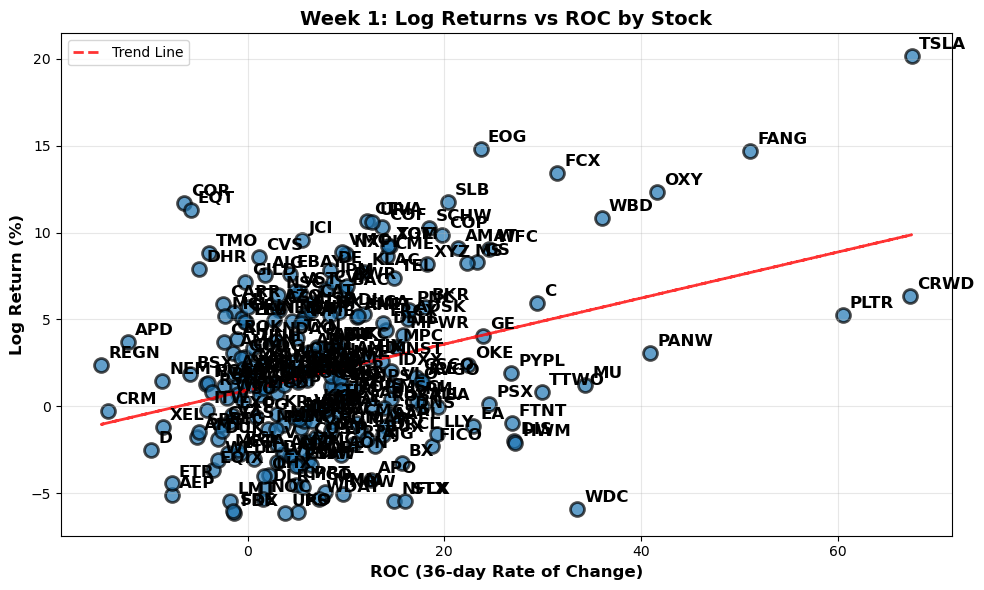

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract week 1 data
week_1_data = weekly_data.iloc[0]  # First row (week 1)

# Prepare data for scatter plot
plot_data = []
for ticker in stocks:
    log_return = week_1_data[(ticker, 'Log_Return_%')]
    roc = week_1_data[(ticker, 'ROC')]
    
    # Only include if both values are not NaN
    if pd.notna(log_return) and pd.notna(roc):
        plot_data.append({
            'Ticker': ticker,
            'Log_Return_%': log_return,
            'ROC': roc
        })

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(plot_df['ROC'], plot_df['Log_Return_%'], 
           s=100, alpha=0.7, edgecolors='black', linewidth=2)

# Add labels for each point
for i, row in plot_df.iterrows():
    plt.annotate(row['Ticker'], 
                (row['ROC'], row['Log_Return_%']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=12, fontweight='bold')

plt.xlabel('ROC (36-day Rate of Change)', fontsize=12, fontweight='bold')
plt.ylabel('Log Return (%)', fontsize=12, fontweight='bold')
plt.title('Week 1: Log Returns vs ROC by Stock', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add a trend line if we have data
if len(plot_df) > 1:
    z = np.polyfit(plot_df['ROC'], plot_df['Log_Return_%'], 1)
    p = np.poly1d(z)
    plt.plot(plot_df['ROC'], p(plot_df['ROC']), 
             "r--", alpha=0.8, linewidth=2, label=f'Trend Line')
    plt.legend()

plt.tight_layout()
plt.show()

/var/folders/6y/spt598r17_dgcfx4prrmwk4m0000gq/T/ipykernel_47854/3735538439.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  week_result_clean = week_result.replace([np.inf, -np.inf], np.nan).infer_objects(copy=False).dropna()
/Users/pedro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Original data shape: (250, 4)
Cleaned data shape: (245, 4)


/Users/pedro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/pedro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/pedro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


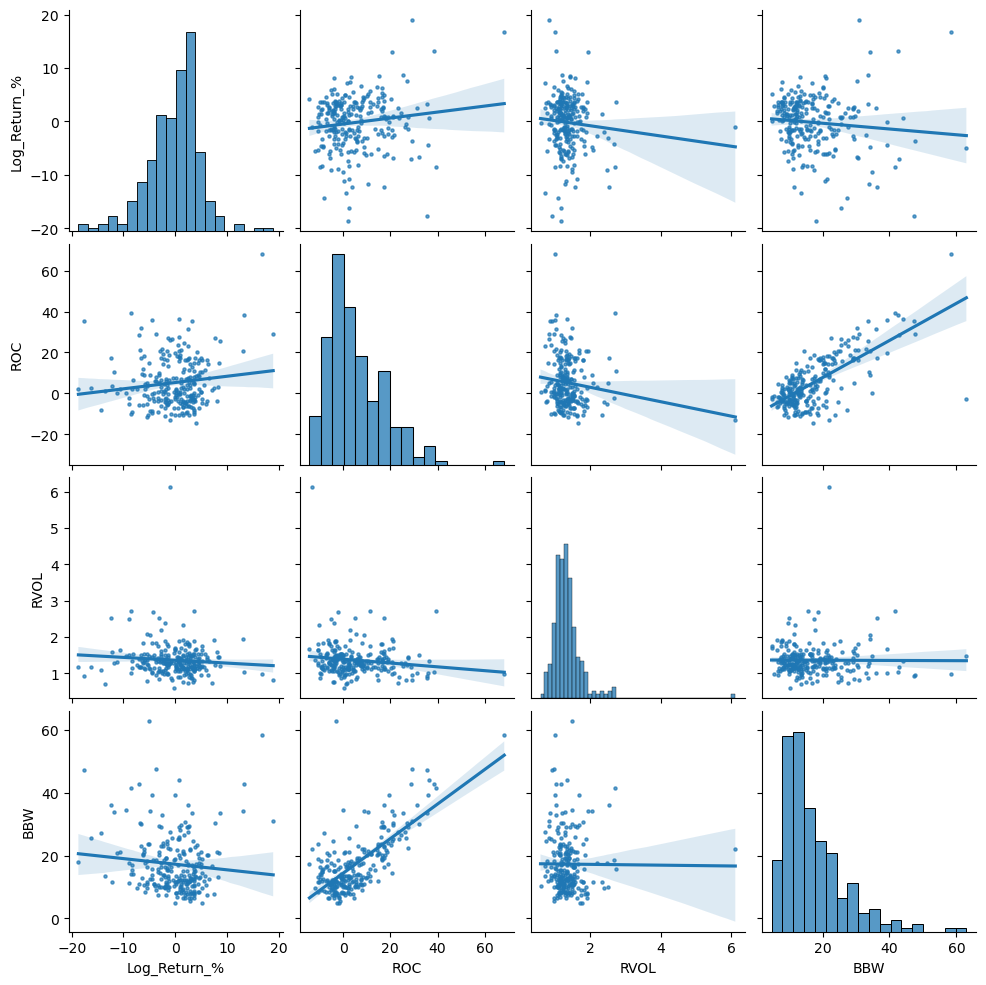

In [61]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# display(week_result)

# Clean the data by replacing inf and -inf values with NaN, then drop NaN rows
week_result_clean = week_result.replace([np.inf, -np.inf], np.nan).infer_objects(copy=False).dropna()

print(f"Original data shape: {week_result.shape}")
print(f"Cleaned data shape: {week_result_clean.shape}")

# Create pairplot for the cleaned week result with trend lines in each scatter plot
# sns.pairplot(week_result_clean, kind='scatter', plot_kws={'alpha': 1})
sns.pairplot(week_result_clean, kind='reg', plot_kws={'scatter_kws': {'alpha': 0.7, 's': 5}}, 
             diag_kind='hist')
plt.show()